POOLED MODEL -> HIERARCHICAL MODEL for pricing!

In [1]:
import pandas as pd   #global env python==3.10.8
import numpy as np
import matplotlib.pyplot as plt
#!pip install pymc>=4

import pymc
import arviz as az
import xarray as xr

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Elasticity coefficient - how much a change in price will affect the sales (volume/demand) at segment (class) or individual SKU level. 

Data is for a product across multiple stores in a single district (location) of the US.
Assumption: Class or segment is a price-promoted group.

In [4]:
df = pd.read_csv('stores_data.csv') 
df.head(5)

,YEAR_WEEK,STORE_ID,Price,Quantity
0,201729,760,84.78,16
1,201729,3134,22.09,4
2,201730,758,32.34,6
3,201730,3104,20.40,4
4,201730,3150,49.97,9


In [9]:
2*df['Price'].values

array([169.56,  44.18,  64.68, ..., 467.18,  97.58,  71.7 ])

In [7]:
#len(df['STORE_ID'].unique())
np.linspace(0, 10, 100)

array([ 0.        ,  0.1010101 ,  0.2020202 ,  0.3030303 ,  0.4040404 ,
        0.50505051,  0.60606061,  0.70707071,  0.80808081,  0.90909091,
        1.01010101,  1.11111111,  1.21212121,  1.31313131,  1.41414141,
        1.51515152,  1.61616162,  1.71717172,  1.81818182,  1.91919192,
        2.02020202,  2.12121212,  2.22222222,  2.32323232,  2.42424242,
        2.52525253,  2.62626263,  2.72727273,  2.82828283,  2.92929293,
        3.03030303,  3.13131313,  3.23232323,  3.33333333,  3.43434343,
        3.53535354,  3.63636364,  3.73737374,  3.83838384,  3.93939394,
        4.04040404,  4.14141414,  4.24242424,  4.34343434,  4.44444444,
        4.54545455,  4.64646465,  4.74747475,  4.84848485,  4.94949495,
        5.05050505,  5.15151515,  5.25252525,  5.35353535,  5.45454545,
        5.55555556,  5.65656566,  5.75757576,  5.85858586,  5.95959596,
        6.06060606,  6.16161616,  6.26262626,  6.36363636,  6.46464646,
        6.56565657,  6.66666667,  6.76767677,  6.86868687,  6.96

In [4]:
df.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2342 entries, 0 to 2341
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   YEAR_WEEK  2342 non-null   int64  
 1   STORE_ID   2342 non-null   int64  
 2   Price      2342 non-null   float64
 3   Quantity   2342 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 73.3 KB


In [1]:
#az.plot_kde(df['Price'].values)

We will use our prior knowledge of the elasticity at the class level 
with our observed price and quantity to estimate an elasticity value of SKU.

In [9]:
#price per unit of product
df['PPU'] = df['Price']/df['Quantity']

Text(0, 0.5, 'Total Units')

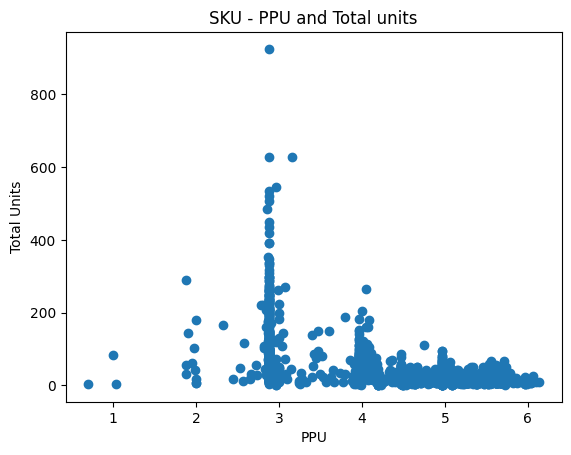

In [11]:
#plt.subplot(2, 1, 1)
plt.scatter(df['PPU'], df['Quantity'])
plt.title('SKU - PPU and Total units')
plt.xlabel('PPU')
plt.ylabel('Total Units')

In [12]:
#elasticity == coefficient of log(PPU)

df['PPU_l'] = np.log(df['PPU'])
df['Quantity_l'] = np.log(df['Quantity'])

log-log transformation ensures that sales does not sink below zero as the price increases and sales exponentially grows as the price decreases.

Text(0, 0.5, 'Log(Total Units)')

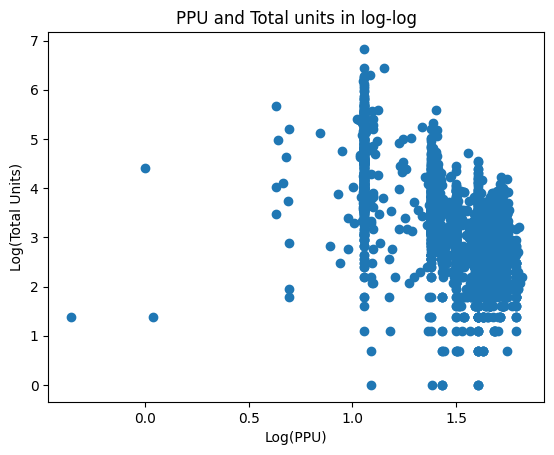

In [13]:
#plt.subplot(2, 1, 2)
plt.scatter(df['PPU_l'], df['Quantity_l'])
plt.title('PPU and Total units in log-log')
plt.xlabel('Log(PPU)')
plt.ylabel('Log(Total Units)')

In [35]:
df['PPU_l'].mean(), df['PPU_l'].std()

(1.481769989333336, 0.244553409882429)

Lets fit a Bayesian linear regression model to this data. By default, models are fit using the NUTS sampler, resulting in a trace of samples representing the marginal posterior distribution of the latent model parameters.

POOLED MODEL: Using data from one location/district

In [22]:
with pymc.Model() as ols_glm:
    #Define priors for intercept and regression coefficients (normal distributions)
    priors = {
        "Intercept": pymc.Normal.dist(mu = 0.0, sigma = 1.0),
        "x": pymc.Normal.dist(mu = 0.0, sigma = 1.0),
        "Slope": pymc.Normal.dist(mu = 0.0, sigma = 1.0)
    }
    #setup model with Normal likelihood (uses HalfCauchy for error prior)
    likelihood = pymc.Normal("y", df['PPU_l'].values)

    trace_ols_glm = pymc.sample(2000, tune = 200, discard_tuned_samples = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y]


Sampling 4 chains for 200 tune and 2_000 draw iterations (800 + 8_000 draws total) took 3605 seconds.


array([[<AxesSubplot: title={'center': 'y'}>,
        <AxesSubplot: title={'center': 'y'}>]], dtype=object)

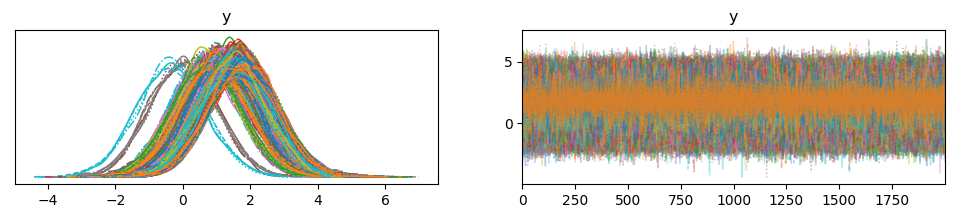

In [25]:
az.plot_trace(trace_ols_glm)     #figsize = (7, 9)

In [31]:
az.summary(trace_ols_glm)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
y[0],1.666,1.005,-0.187,3.527,0.009,0.008,11712.0,5349.0,1.0
y[1],1.702,0.981,-0.138,3.565,0.009,0.008,11277.0,5301.0,1.0
y[2],1.689,1.003,-0.251,3.528,0.009,0.007,13668.0,5352.0,1.0
y[3],1.633,0.977,-0.263,3.406,0.009,0.008,11001.0,5493.0,1.0
y[4],1.698,0.980,-0.171,3.450,0.009,0.007,12515.0,5049.0,1.0
...,...,...,...,...,...,...,...,...,...
y[2337],1.809,1.000,-0.006,3.820,0.010,0.008,11094.0,5482.0,1.0
y[2338],1.496,0.991,-0.375,3.333,0.010,0.008,9793.0,4642.0,1.0
y[2339],1.611,0.983,-0.121,3.538,0.009,0.007,12145.0,5562.0,1.0
y[2340],1.813,0.995,-0.097,3.666,0.010,0.008,10929.0,5469.0,1.0


In [34]:
az.summary(trace_ols_glm)['mean'].mean() 

1.4817557643040136

In [37]:
az.summary(trace_ols_glm)['sd'].mean() 

0.9999368061485909

The trace plot represents the KDE and convergence of the model. Since we are running 4 Markov chains, closer the 4 dashed lines, more representative our model is. The mean of PPU is 1.48. 

HIERARCHICAL MODEL: The elasticity values obtained from linear regression model (prior beliefs of elasticity at the segment level - pooled model) will be represented in the parameters of hierarchical model.

In [36]:
df['PPU_l'].min(), df['PPU_l'].max()

(-0.35667494393873245, 1.8142817065768768)

We have a distribution of possible elasticity values (observed data) with a mean of 1.48 and a standard deviation of ~0.24. We can get as many elasticity values as we want by sampling this distribution.

In [38]:
occurences = np.random.normal(1.48, 0.24, 500) #number of sale transactions over a time-period

with pymc.Model() as hierarchical_model:  #model specifications
    #priors
    prior_sigma = pymc.HalfCauchy("prior_sigma", beta = 0.5) 
    prior_mu = pymc.Normal('prior_mu', mu = 1.48, sigma = 0.98) #info from glm
    intercept = pymc.Normal("Intercept", mu = 0.0, sigma = 1.0)
    slope = pymc.Normal("slope", mu = 0.0, sigma = 1.0)

    likelihood = pymc.Normal("y", mu = prior_mu, sigma = prior_sigma, observed = occurences) #mu = intercept + slope*x

with hierarchical_model:
    #draw 2000 posterior samples
    trace = pymc.sample(draws = 2000, tune = 200, discard_tuned_samples = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [prior_sigma, prior_mu, Intercept, slope]


Sampling 4 chains for 200 tune and 2_000 draw iterations (800 + 8_000 draws total) took 571 seconds.


array([[<AxesSubplot: title={'center': 'prior_mu'}>,
        <AxesSubplot: title={'center': 'prior_mu'}>],
       [<AxesSubplot: title={'center': 'Intercept'}>,
        <AxesSubplot: title={'center': 'Intercept'}>],
       [<AxesSubplot: title={'center': 'slope'}>,
        <AxesSubplot: title={'center': 'slope'}>],
       [<AxesSubplot: title={'center': 'prior_sigma'}>,
        <AxesSubplot: title={'center': 'prior_sigma'}>]], dtype=object)

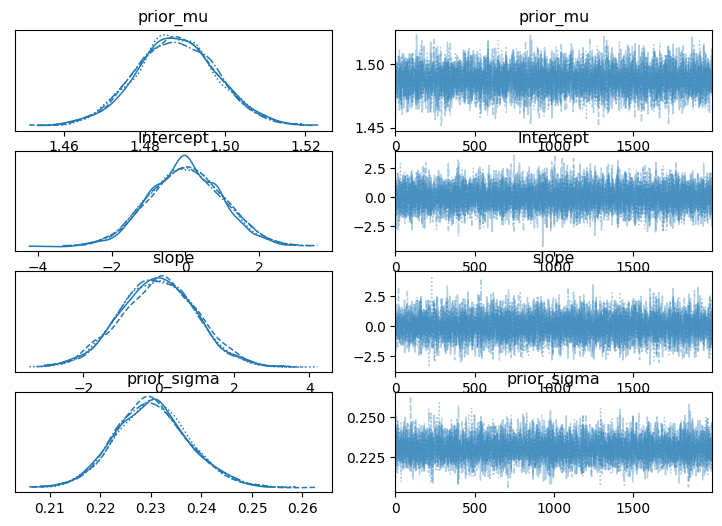

In [43]:
az.plot_trace(trace, figsize = (9, 6))

array([<AxesSubplot: title={'center': 'prior_mu'}>,
       <AxesSubplot: title={'center': 'Intercept'}>,
       <AxesSubplot: title={'center': 'slope'}>,
       <AxesSubplot: title={'center': 'prior_sigma'}>], dtype=object)

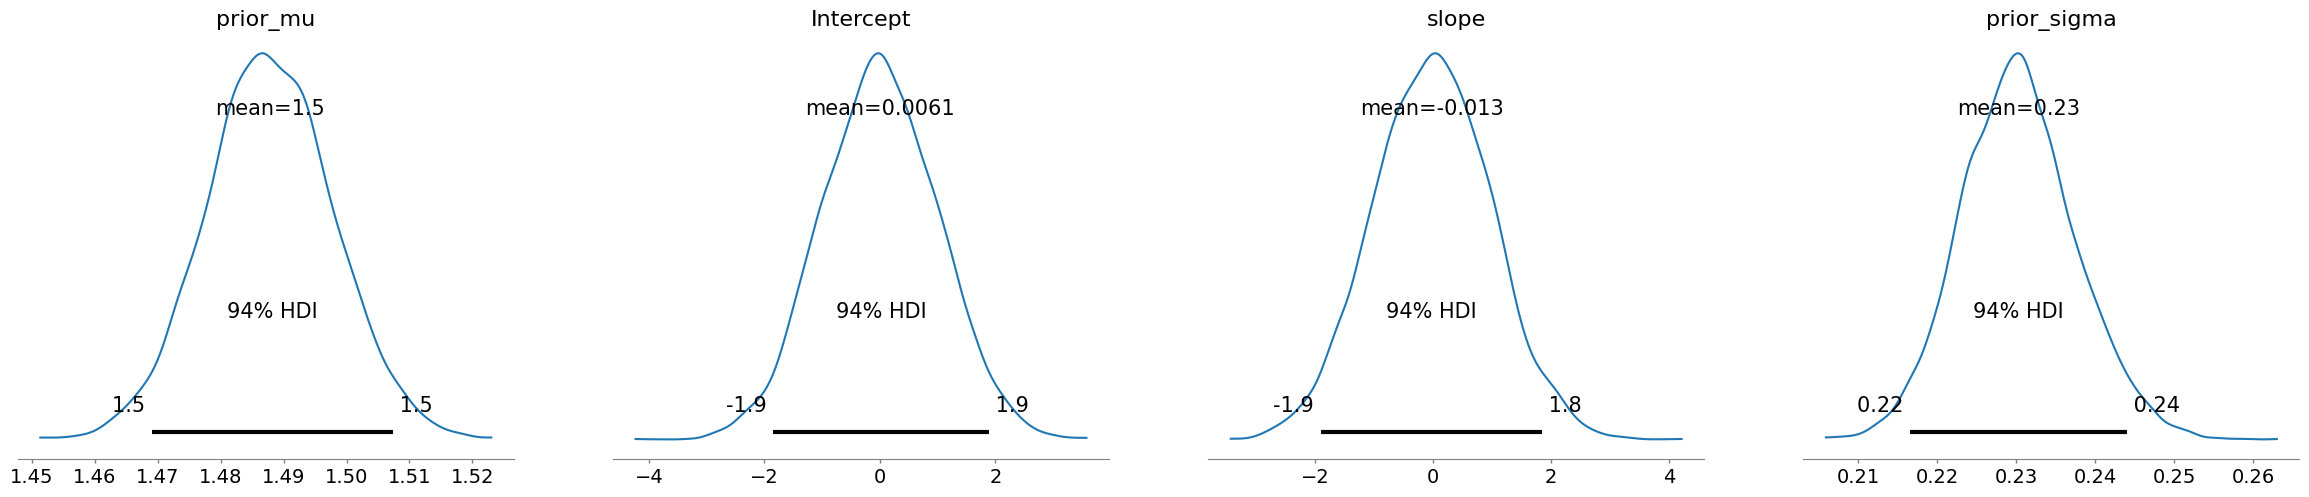

In [40]:
az.plot_posterior(trace)

Elasticity is within this range (mean 1.5) 94% (highest density interval) of the times.

array([[<AxesSubplot: ylabel='Intercept'>, <AxesSubplot: >,
        <AxesSubplot: >],
       [<AxesSubplot: ylabel='slope'>, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: xlabel='prior_mu', ylabel='prior_sigma'>,
        <AxesSubplot: xlabel='Intercept'>, <AxesSubplot: xlabel='slope'>]],
      dtype=object)

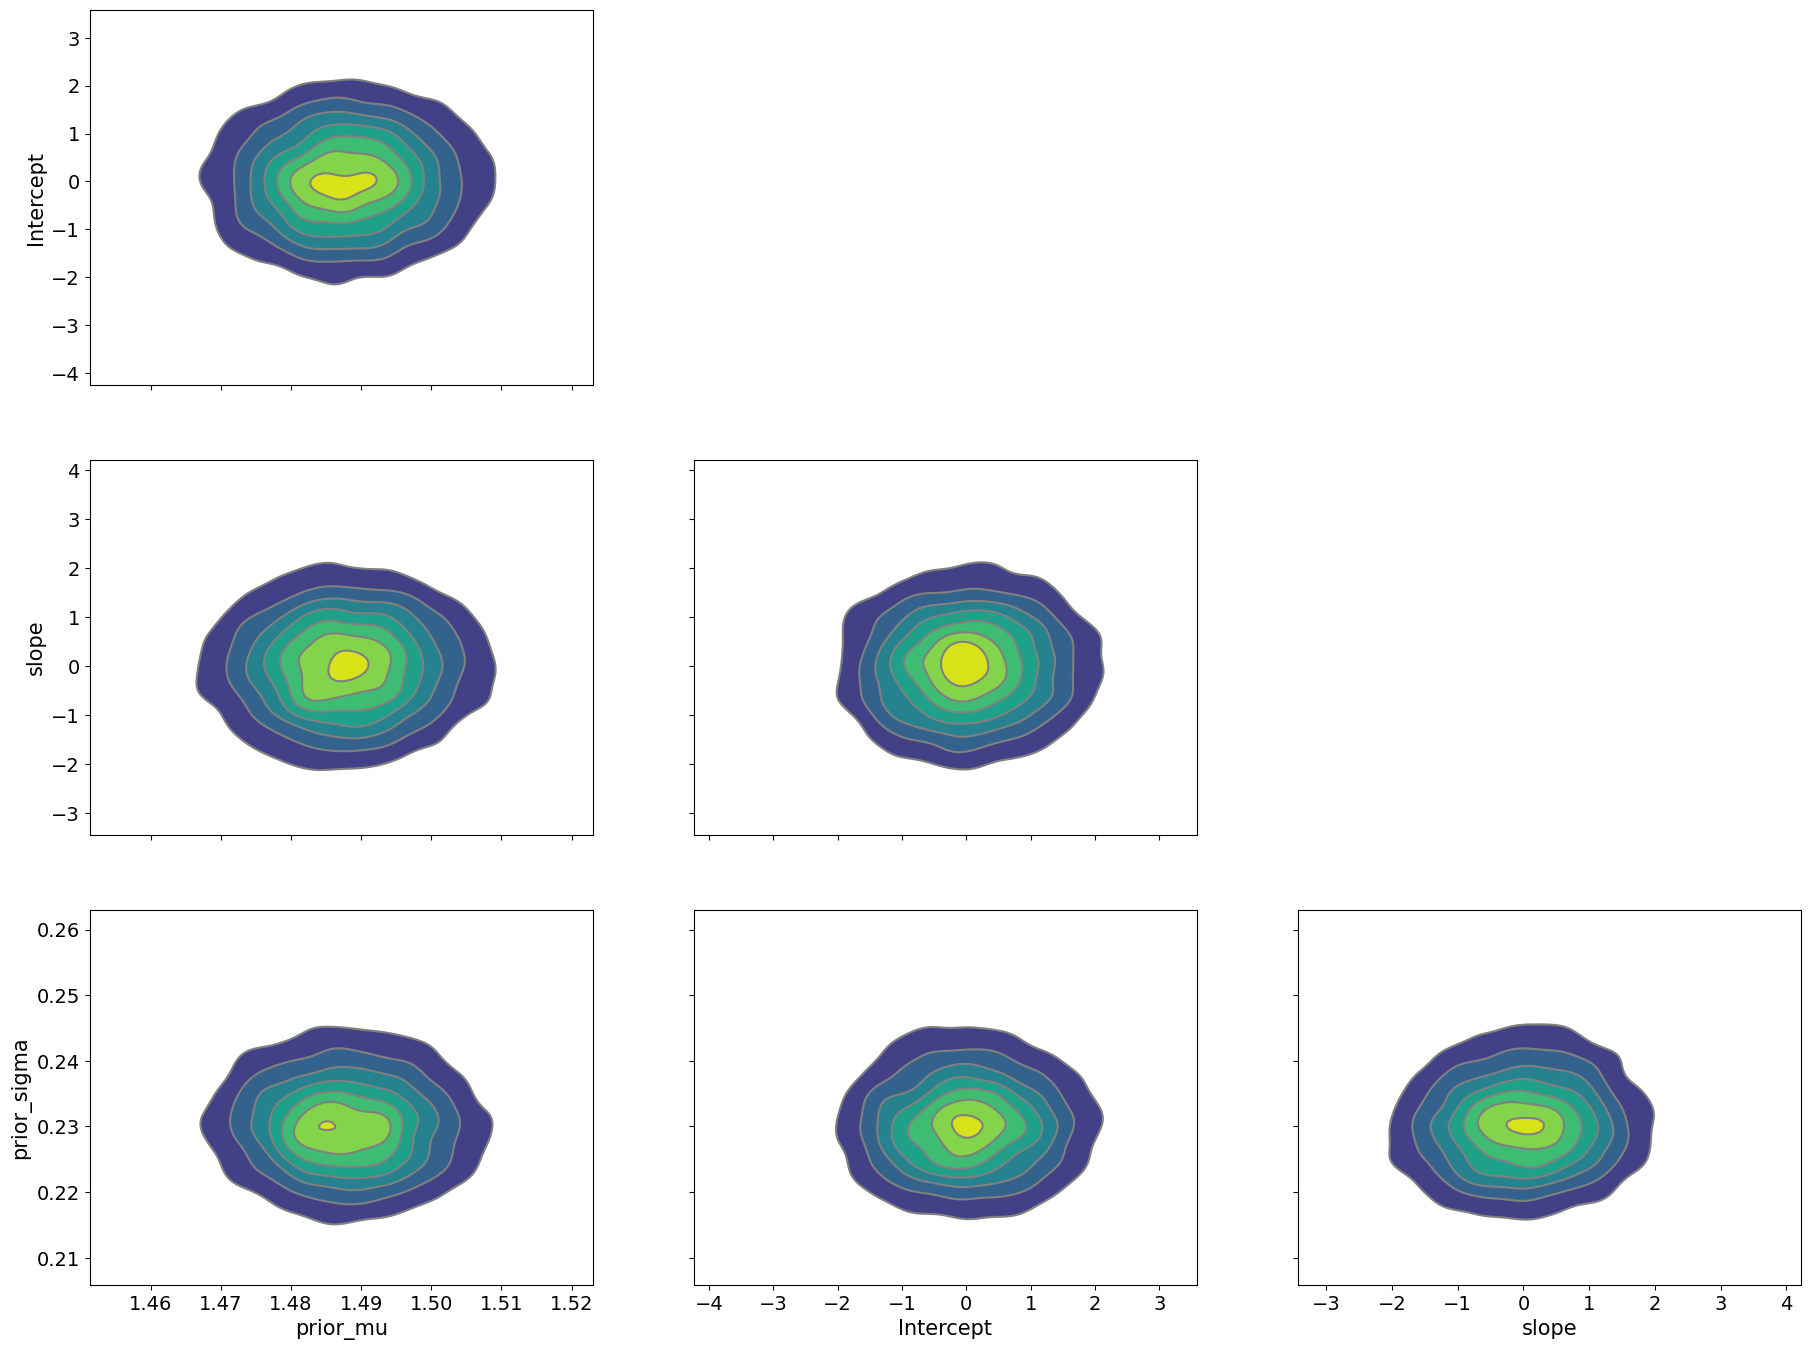

In [41]:
#az.plot_autocorr(trace, max_lag = 10)

az.plot_pair(trace, kind = 'kde') #model evaluation

In [44]:
az.summary(trace) #mean, standard deviation, HDI

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prior_mu,1.488,0.010,1.469,1.507,0.00,0.000,9961.0,5567.0,1.0
Intercept,0.006,1.004,-1.851,1.896,0.01,0.012,10603.0,5739.0,1.0
slope,-0.013,0.997,-1.907,1.847,0.01,0.012,10052.0,5785.0,1.0
prior_sigma,0.230,0.007,0.217,0.244,0.00,0.000,10654.0,5183.0,1.0


One can increase/decrease the number of occurences as per use case and see how these distributions change. 

In [50]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [52]:
trace.observed_data

<xarray.Dataset>
Dimensions:  (y_dim_0: 500)
Coordinates:
  * y_dim_0  (y_dim_0) int32 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
Data variables:
    y        (y_dim_0) float64 1.525 1.139 1.067 1.955 ... 1.8 1.479 1.423 1.22
Attributes:
    created_at:                 2023-08-11T17:26:33.220144
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.7.0

In [53]:
trace.posterior

<xarray.Dataset>
Dimensions:      (chain: 4, draw: 2000, dim_0: 2000)
Coordinates:
  * chain        (chain) int32 0 1 2 3
  * draw         (draw) int32 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
Dimensions without coordinates: dim_0
Data variables:
    prior_mu     (chain, draw) float64 1.473 1.46 1.479 ... 1.485 1.49 1.48
    Intercept    (chain, draw) float64 -1.529 -1.526 0.3549 ... 2.19 -1.341
    slope        (chain, draw) float64 -0.008839 -0.7536 ... -0.04364 -0.7678
    prior_sigma  (chain, draw) float64 0.2398 0.2366 0.2312 ... 0.2369 0.2265
    y_model      (chain, draw, dim_0) float64 -1.529 -1.529 ... -2.876 -2.877
Attributes:
    created_at:                 2023-08-11T17:26:33.128478
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.7.0
    sampling_time:              571.1070935726166
    tuning_steps:               200

In [54]:
trace.sample_stats

<xarray.Dataset>
Dimensions:                (chain: 4, draw: 2000)
Coordinates:
  * chain                  (chain) int32 0 1 2 3
  * draw                   (draw) int32 0 1 2 3 4 5 ... 1995 1996 1997 1998 1999
Data variables: (12/17)
    acceptance_rate        (chain, draw) float64 0.9817 0.897 ... 0.8885 1.0
    diverging              (chain, draw) bool False False False ... False False
    index_in_trajectory    (chain, draw) int64 -6 1 3 6 3 4 5 ... 2 -6 -2 3 4 4
    reached_max_treedepth  (chain, draw) bool False False False ... False False
    n_steps                (chain, draw) float64 7.0 7.0 3.0 7.0 ... 7.0 7.0 7.0
    step_size              (chain, draw) float64 0.8309 0.8309 ... 1.058 1.058
    ...                     ...
    process_time_diff      (chain, draw) float64 0.1562 0.1562 ... 0.1562 0.125
    smallest_eigval        (chain, draw) float64 nan nan nan nan ... nan nan nan
    step_size_bar          (chain, draw) float64 0.6573 0.6573 ... 0.5654 0.5654
    perf_counter_diff      (chain, draw) float64 0.1488 0.1508 ... 0.1601 0.1237
    tree_depth             (chain, draw) int64 3 3 2 3 3 3 3 3 ... 3 3 3 3 3 3 3
    lp                     (chain, draw) float64 19.2 17.05 21.83 ... 19.41 20.7
Attributes:
    created_at:                 2023-08-11T17:26:33.202610
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.7.0
    sampling_time:              571.1070935726166
    tuning_steps:               200